# Playground 9:  Segmentation workflows for lamin b1 (interphase)

This notebook contains the workflows for lamin B1 (interphase-specific), and serves as a starting point for developing a classic segmentation workflow for your data with shell-like shapes.

----------------------------------------

Cell Structure Observations:

* [Lamin B1](https://www.allencell.org/cell-observations/category/lamin)

----------------------------------------

Key steps of the workflows:

* Min-max intensity normalization / Auto-contrast
* 3D Gaussian smoothing 
* 2D filament filter 
* watershed

In [2]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from aicssegmentation.core.utils import get_middle_frame, hole_filling, get_3dseed_from_mid_frame
from skimage.morphology import remove_small_objects, watershed, dilation, ball

ModuleNotFoundError: No module named 'aicssegmentation'

## Loading the data

In [2]:
FILE_NAME = '../../data/lamin/img_004.czi'
reader = AICSImage(FILE_NAME) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 7, 60, 624, 924)


## Preview of the image

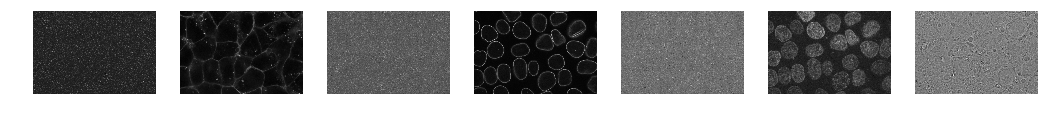

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [5]:
#####################
structure_channel = 3
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f7a43d28f…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * Parameter for Lamin B1 (interphase specific):  `intensity_scaling_param = [4000]`


* **Smoothing** 

    3D gaussian smoothing with `gaussian_smoothing_sigma = 1`. The large the value is, the more the image will be smoothed. 

In [6]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [4000]
gaussian_smoothing_sigma = 1
################################
# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

intensity normalization: using min-max normalization with absolute intensity upper bound 4000
intensity normalization completes


In [7]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f79f0c0e8…

### Step 2: Core Algorithm

#### apply 2d filament filter on the middle frame 

* **Part 1: get the middle frame**: We support two methods to get middle frame: `method='intensity'` and `method='z'`. `'intensity'` method assumes the number of foreground pixels (estimated by intensity) along z dimension has a unimodal distribution (such as Gaussian). Then, the middle frame is defined as the frame with peak of the distribution along z. `'z'` method simply return the middle z frame. 

    * Paramete for lamin b1 (interphase-specific):  `method='intensity'`


* **Part 2: apply 2d filament filter on the middle frame**

    * Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
        * `scale_x` is set based on the estimated width of your target curvilinear shape. For example, if visually the width of the objects is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have objects of very different sizes.  
        * `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf fatter segmentation, while larger `cutoff_x` could be less permisive and yield less objects and slimmer segmentation. 
    * Parameter for lamin b1 (interphase-specific):  `f2_param = [[0.5, 0.01]]`

In [8]:
mid_z = get_middle_frame(structure_img_smooth, method='intensity')

In [9]:
################################
## PARAMETERS for this step ##
f2_param = [[1, 0.01],[2, 0.01],[3, 0.01]]
################################

bw_mid_z = filament_2d_wrapper(structure_img_smooth[mid_z,:,:], f2_param)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [10]:
view(segmentation_quick_view(bw_mid_z))

Viewer(rendered_image=<itkImagePython.itkImageUC2; proxy of <Swig Object of type 'itkImageUC2 *' at 0x7f7a4308…

#### Part 3: apply watershed to get the shell

In [12]:
####################
hole_max = 40000
hole_min = 400
####################

bw_fill_mid_z = hole_filling(bw_mid_z, hole_min, hole_max)
seed = get_3dseed_from_mid_frame(np.logical_xor(bw_fill_mid_z, bw_mid_z), struct_img.shape, mid_z, hole_min)
bw_filled = watershed(struct_img, seed.astype(int), watershed_line=True)>0

# get the shell
seg = np.logical_xor(bw_filled, dilation(bw_filled, selem=ball(1)))

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [13]:
viewer_bw = view(segmentation_quick_view(seg))
viewer_bw

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f79f0c0…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side
##### You may select an ROI to inspect the details

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_bw'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [14]:
# Option 1:
view(seg_fluo_side_by_side(struct_img,seg,roi=['ROI',viewer_bw.roi_slice()]))

# Option 2: 
# view(seg_fluo_side_by_side(struct_img,seg,roi=['M',[570,370,730,440]]))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f79f0c0ee…

### You may also physically save the segmentation results into a ome.tif file

In [14]:
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('../../data/lamin/result/test_segmentation.tiff')
writer.save(out)